# CONTROL LIBRARY EXAMPLES

# Preliminaries

In [1]:
from controlSBML.control_extensions.state_space_tf import StateSpaceTF

import control
import numpy as np
import sympy
import matplotlib.pyplot as plt

# Predatory Prey

In [2]:

def predprey_rhs(t, x, u, params):
    # Parameter setup
    a = params.get('a', 3.2)
    b = params.get('b', 0.6)
    c = params.get('c', 50.)
    d = params.get('d', 0.56)
    k = params.get('k', 125)
    r = params.get('r', 1.6)

    # Map the states into local variable names
    H = x[0]
    L = x[1]

    # Compute the control action (only allow addition of food)
    u_0 = u if u > 0 else 0

    # Compute the discrete updates
    dH = (r + u_0) * H * (1 - H/k) - (a * H * L)/(c + H)
    dL = b * (a * H *  L)/(c + H) - d * L

    return [dH, dL]

In [3]:
io_predprey = control.NonlinearIOSystem(
    predprey_rhs, None, inputs=('u'), outputs=('H', 'L'),
    states=('H', 'L'), name='predprey')

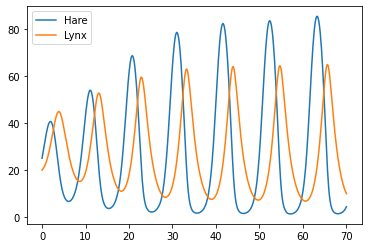

In [4]:
# Simulate the system
X0 = [25, 20]                 # Initial H, L
T = np.linspace(0, 70, 500)   # Simulation 70 years of time

# Simulate the system
t, y = control.input_output_response(io_predprey, T, 0, X0)

# Plot the response
plt.figure(1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['Hare', 'Lynx'])
plt.show(block=False)

In [5]:
# Create a feedback controller. Step 1: Find an equalibrium point
eqpt = control.find_eqpt(io_predprey, X0, 0)
xeq = eqpt[0]                         # choose the nonzero equilibrium point
lin_predprey = control.linearize(io_predprey, xeq, 0)

/home/ubuntu/controlSBML/ctl/lib/python3.6/site-packages/control/iosys.py:1007: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [6]:
# Step 2: Construct the controller via pole placement
K = control.place(lin_predprey.A, lin_predprey.B, [-0.1, -0.2])
A, B = lin_predprey.A, lin_predprey.B
C = np.array([[0, 1]])                # regulated output = number of lynxes
kf = -1/(C @ np.linalg.inv(A - B @ K) @ B)

In [7]:
# Construct the controller
io_controller = control.NonlinearIOSystem(
  None,
  lambda t, x, u, params: -K @ (u[1:] - xeq) + kf * (u[0] - xeq[1]),
  inputs=('Ld', 'u1', 'u2'), outputs=1, name='control')

In [8]:
# Create the closed loop system
io_closed = control.interconnect(
  [io_predprey, io_controller],       # systems
  connections=[
    ['predprey.u', 'control.y[0]'],
    ['control.u1',  'predprey.H'],
    ['control.u2',  'predprey.L']
  ],
  inplist=['control.Ld'],
  outlist=['predprey.H', 'predprey.L', 'control.y[0]']
)

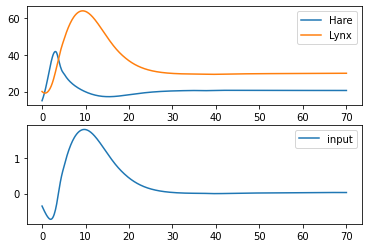

In [9]:
# Simulate the system
t, y = control.input_output_response(io_closed, T, 30, [15, 20])

# Plot the response
plt.figure(2)
plt.subplot(2, 1, 1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['Hare', 'Lynx'])
plt.subplot(2, 1, 2)
plt.plot(t, y[2])
plt.legend(['input'])
plt.show(block=False)

# Vertial Takeoff and Landing: TF + Bode plots

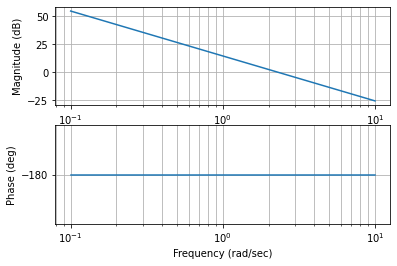

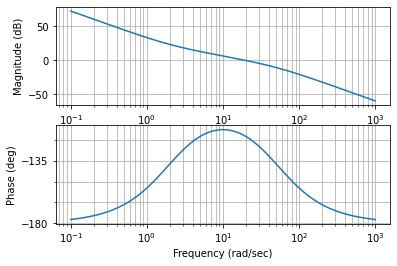

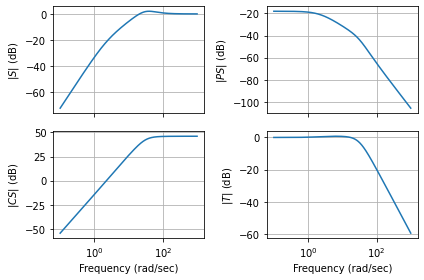

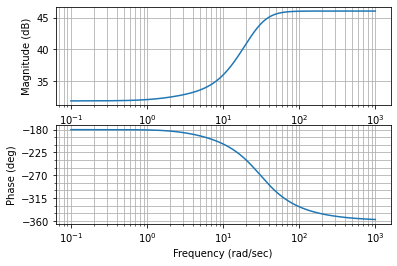

In [10]:
# pvtol-nested.py - inner/outer design for vectored thrust aircraft
# RMM, 5 Sep 09
#
# This file works through a fairly complicated control design and
# analysis, corresponding to the planar vertical takeoff and landing
# (PVTOL) aircraft in Astrom and Murray, Chapter 11.  It is intended
# to demonstrate the basic functionality of the python-control
# package.
#

import os
import matplotlib.pyplot as plt  # MATLAB plotting functions
from control.matlab import *    # MATLAB-like functions
import numpy as np

# System parameters
m = 4               # mass of aircraft
J = 0.0475          # inertia around pitch axis
r = 0.25            # distance to center of force
g = 9.8             # gravitational constant
c = 0.05            # damping factor (estimated)

# Transfer functions for dynamics
Pi = tf([r], [J, 0, 0])  # inner loop (roll)
Po = tf([1], [m, c, 0])  # outer loop (position)

#
# Inner loop control design
#
# This is the controller for the pitch dynamics.  Goal is to have
# fast response for the pitch dynamics so that we can use this as a
# control for the lateral dynamics
#

# Design a simple lead controller for the system
k, a, b = 200, 2, 50
Ci = k*tf([1, a], [1, b])  # lead compensator
Li = Pi*Ci

# Bode plot for the open loop process
plt.figure(1)
bode(Pi)

# Bode plot for the loop transfer function, with margins
plt.figure(2)
bode(Li)

# Compute out the gain and phase margins
#! Not implemented
# gm, pm, wcg, wcp = margin(Li)

# Compute the sensitivity and complementary sensitivity functions
Si = feedback(1, Li) 
Ti = Li*Si

# Check to make sure that the specification is met 
plt.figure(3)
gangof4(Pi, Ci) 

# Compute out the actual transfer function from u1 to v1 (see L8.2 notes)
# Hi = Ci*(1-m*g*Pi)/(1+Ci*Pi)
Hi = parallel(feedback(Ci, Pi), -m*g*feedback(Ci*Pi, 1)) 

plt.figure(4)
plt.clf()
plt.subplot(221)
bode(Hi)

# Now design the lateral control system
a, b, K = 0.02, 5, 2
Co = -K*tf([1, 0.3], [1, 10])  # another lead compensator
Lo = -m*g*Po*Co                                                                                                                        

# State Space to Transfer Function

``ss2tf`` does the conversion from state space model to transfer function for a single input, single output system.
Conceptually, this is done by a similarity transformation in which the ${\bf A}$ matrix is restructured into the "controlability" form: (a) the first row has a leading 1; (b) row $n > 1$ has its only non-zero column as $n + 1$. That is, the new state variables are $x_{n+1} = \dot{x}_n$. If the matrix is singular, then some rows are zero. From this, it is easy to construct a transfer function.

In [11]:
A_mat = [[1., -2], [3, -4]]
B_mat = np.identity(2)
C_mat = np.identity(2)
D_mat = 0*np.identity(2)
sys_mimo = StateSpace(A_mat, B_mat, C_mat, D_mat)
sys1 = ss2tf(sys_mimo)
sys1

TransferFunction([[array([1., 4.]), array([-2.])], [array([3.]), array([ 1., -1.])]], [[array([1., 3., 2.]), array([1., 3., 2.])], [array([1., 3., 2.]), array([1., 3., 2.])]])

In [12]:
s = sympy.symbols("s")

In [13]:
#A_mat = np.random.randint(0, 10, (size, size))
size= np.shape(A_mat)[0]
smat = sympy.eye(size) *s - sympy.Matrix(A_mat)
smat.inv()

Matrix([
[(3.0*s + 12.0)/(3.0*s**2 + 9.0*s + 6.0),          -6.0/(3.0*s**2 + 9.0*s + 6.0)],
[               -3/(-s**2 - 3.0*s - 2.0), (1.0*s - 1.0)/(1.0*s**2 + 3.0*s + 2.0)]])

In [14]:
ss_tf = StateSpaceTF(sys_mimo)
print(ss_tf)

(input, output)


(1, 1):      s + 4
            -------------
            s^2 + 3 s + 2

(1, 2):       -2
            -------------
            s^2 + 3 s + 2

(2, 1):        3
            -------------
            s^2 + 3 s + 2

(2, 2):      s - 1
            -------------
            s^2 + 3 s + 2



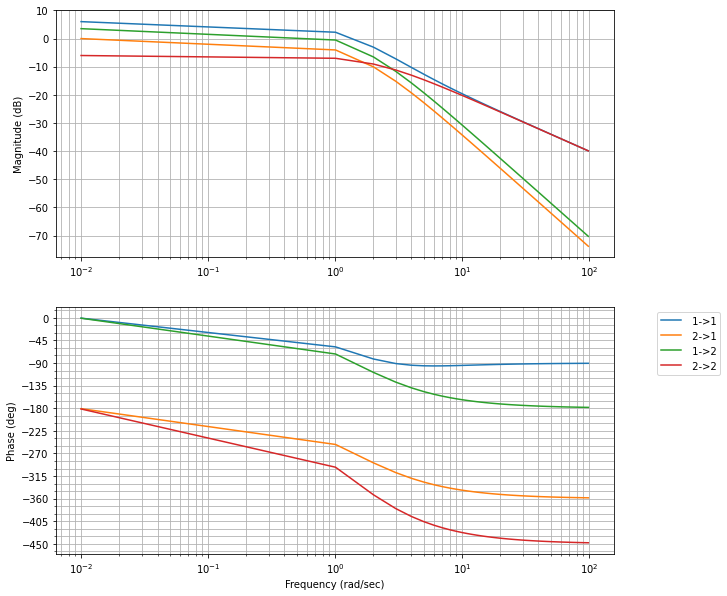

In [15]:
ss_tf.plotBode(legend_crd=(1.2, 1))

In [16]:
func11 = lambda s: 20*np.log10(np.abs( (s+4)/(s**2 + 3*s + 2)))
func12 = lambda s: 20*np.log10(np.abs( (-2)/(s**2 + 3*s + 2)))
func21 = lambda s: 20*np.log10(np.abs( (3)/(s**2 + 3*s + 2)))
func22 = lambda s: 20*np.log10(np.abs( (s - 1)/(s**2 + 3*s + 2)))
for f in [func11, func12, func21, func22]:
    print(f(0.1))

4.983437536551822
-1.2516396845632625
2.2701854965503623
-8.187389409056388


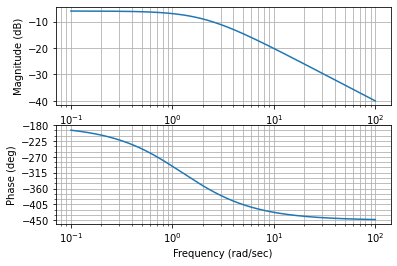

In [17]:
_ = control.bode(ss_tf.dataframe.loc["2", "2"])

In [18]:
A = [[1., -2], [3, -4]]
B = [[5.], [7]]
C = [[6., 8]]
D = [[9.]]
sys2 = ss2tf(A, B, C, D)
sys2

TransferFunction(array([  9., 113., 118.]), array([1., 3., 2.]))

In [19]:
sys = control.StateSpace(A, B, C, D)
sys

StateSpace(array([[ 1., -2.],
       [ 3., -4.]]), array([[5.],
       [7.]]), array([[6., 8.]]), array([[9.]]))

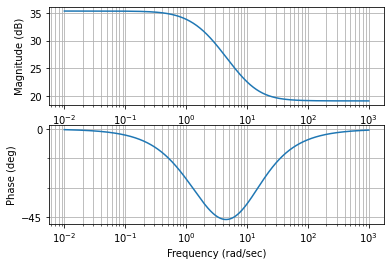

In [20]:
_ = bode(sys[0, 0])

In [21]:
tf = ss2tf(sys)

One description of a MIMO system is the matrix of input, output transfer functions. Another is to diagonlize the system.

In [22]:
tf.frequency_response(np.pi)


(array([29.01021596]), array([-0.77771055]), array([3.14159265]))

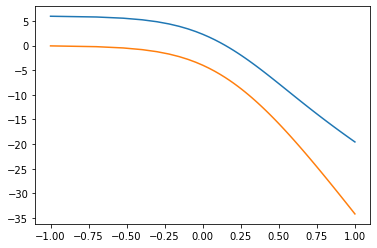

In [23]:
mag, phase, angle = control.freqresp(sys1, [0.1*v for v in range(1, 101)])
plt.plot(np.log10(angle), 20*np.log10(mag[0][0,:]))
plt.plot(np.log10(angle), 20*np.log10(mag[0][1,:]))

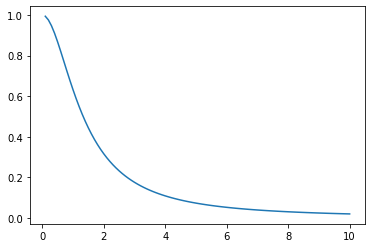

In [24]:
plt.plot(angle, mag[0][1,:])

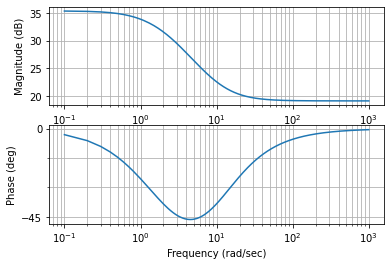

In [25]:
sys = control.TransferFunction(tf[0, 0])
ax = plt.subplots(1)
mag, phase, angle = bode(sys, [0.1*v for v in range(1, 10000)])

In [26]:
20*np.log10(mag)

array([35.39606105, 35.33435066, 35.235321  , ..., 19.08539952,
       19.08539941, 19.0853993 ])

In [27]:
angle

array([1.000e-01, 2.000e-01, 3.000e-01, ..., 9.997e+02, 9.998e+02,
       9.999e+02])